In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from mplsoccer import VerticalPitch, add_image
from PIL import Image
from urllib.request import urlopen
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.patheffects as path_effects
from scipy.ndimage import gaussian_filter
import seaborn as sns
plt.style.use('dark_background')
%config InlineBackend.figure_format='retina'

Load data

In [2]:
# load the dataset with outliers removed and some fake points added to make it smoother
cols = ['x', 'y', 'goal']
df_shots = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
df_fake = pd.read_parquet(os.path.join('..', 'data', 'fake_shots.parquet'))
df_shots = pd.concat([df_shots[cols], df_fake[cols]])
df_goals = df_shots[df_shots.goal].copy()
print('Number of shots:', len(df_shots))
print('Number of goals:', len(df_goals))

Number of shots: 74958
Number of goals: 7895


In [3]:
#df_wyscout_shots = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'shots.parquet'))
#df_statsbomb_shots = pd.read_parquet(os.path.join('..', 'data', 'statsbomb', 'shots.parquet'))

Combine data

In [4]:
#cols = ['x', 'y', 'goal']
#df_shots = pd.concat([df_wyscout_shots[cols], df_statsbomb_shots[cols]])
#print('Number of shots:', len(df_shots))

Subset goals

In [5]:
#df_goals = df_shots[df_shots.goal].copy()
#print('Number of goals:', len(df_goals))

Load the statsbomb logo

In [6]:
logo = np.array(Image.open('SB_Regular.png'))

# Basic scatter plot of goals scored and histogram

In [7]:
pitch = VerticalPitch(half=True, line_zorder=2, pitch_type='uefa',
                      pad_left=-13.25, pad_right=-13.25, pad_bottom=-12, pad_top=1)

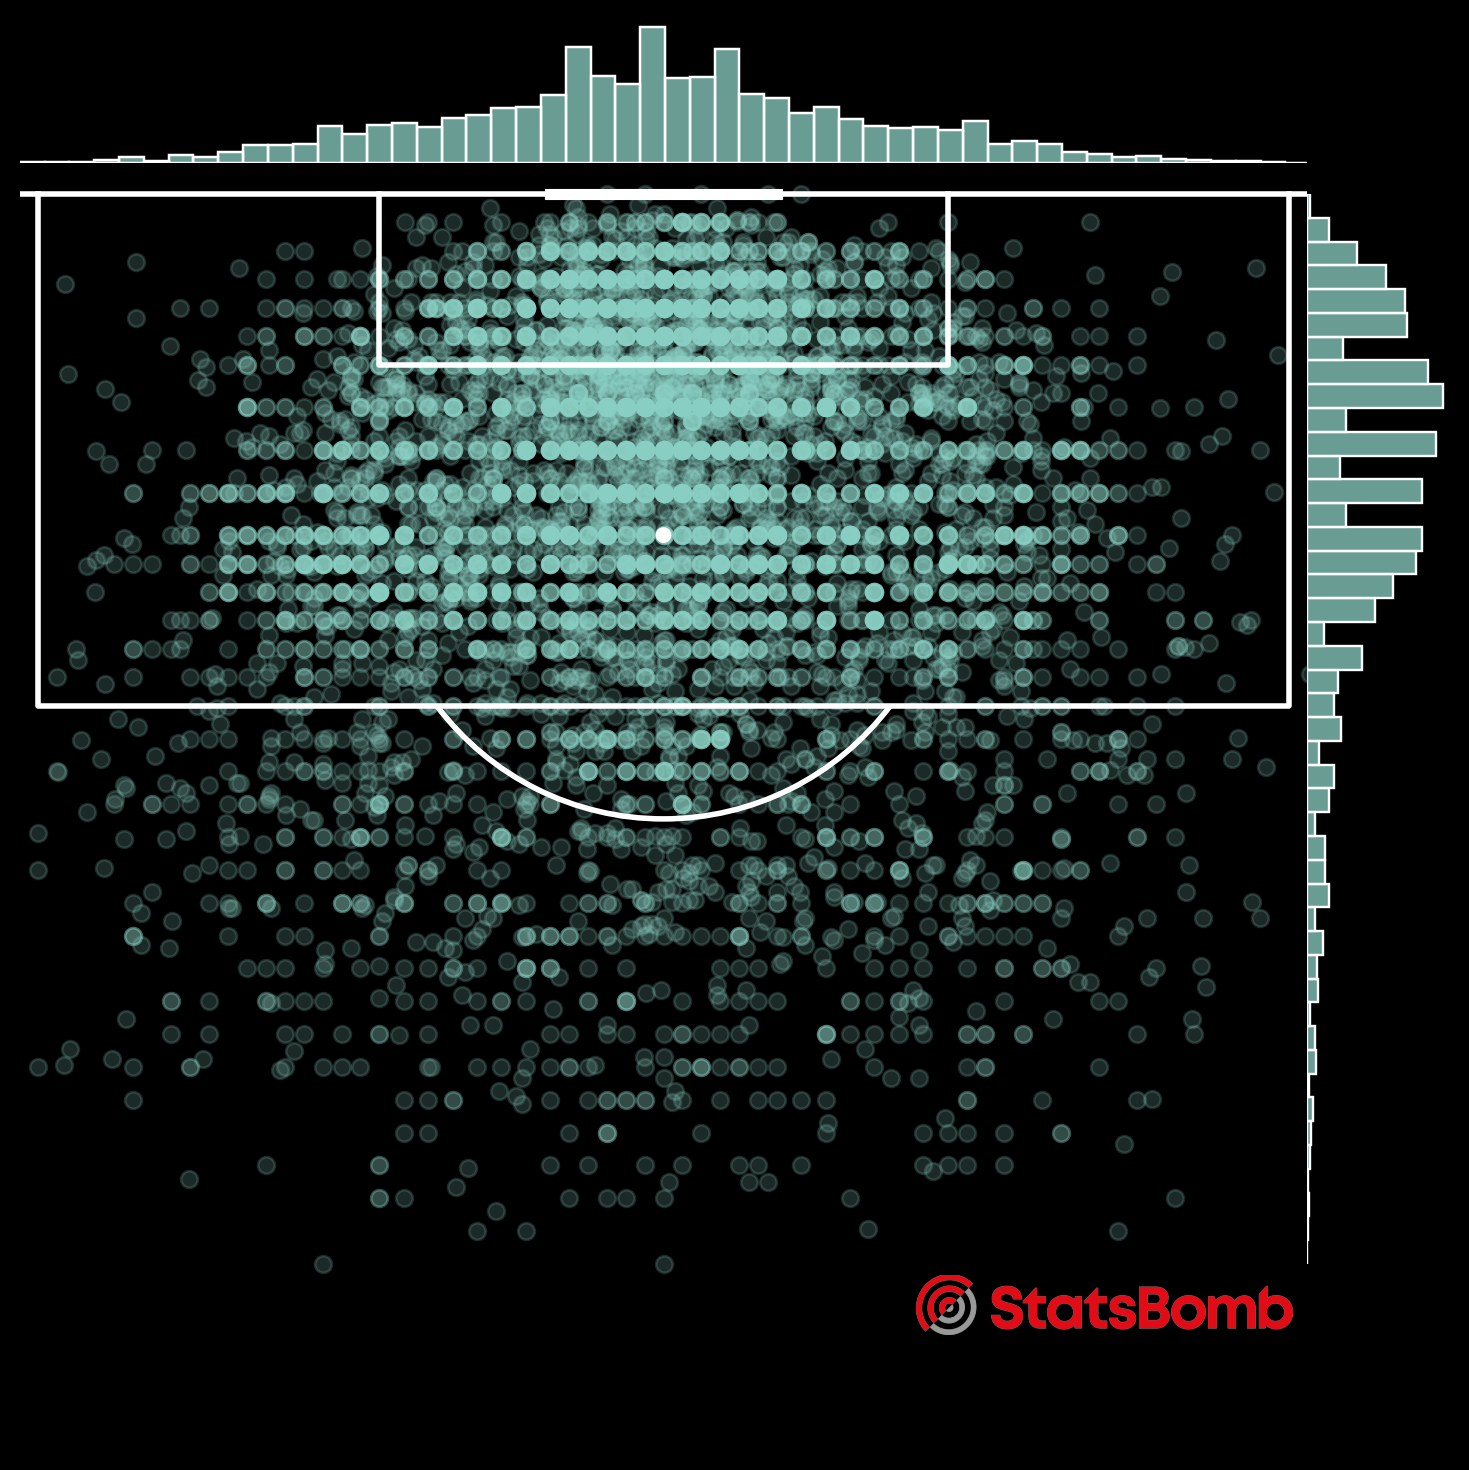

In [8]:
fig, axs = pitch.jointgrid(figheight=10, ax_left=False, title_height=0, endnote_height=0)
pitch.scatter(df_goals.x, df_goals.y, ax=axs['pitch'], alpha=0.2)
ax_image1 = add_image(logo, fig, left=0.62, bottom=0.2, width=0.25, alpha=1, interpolation='hanning')
kde_x = sns.histplot(x=df_goals.y, ax=axs['top'])
kde_y = sns.histplot(y=df_goals.x, ax=axs['right'])
axs['top'].axis('off')
axs['right'].axis('off')
fig.savefig(os.path.join('..', 'figures', '09_joint_plot_shots_example.png'),
            bbox_inches='tight', pad_inches=0)

# Shot distribution using Kernel Density Estimation and Scott's Rule of Thumb for bandwidth

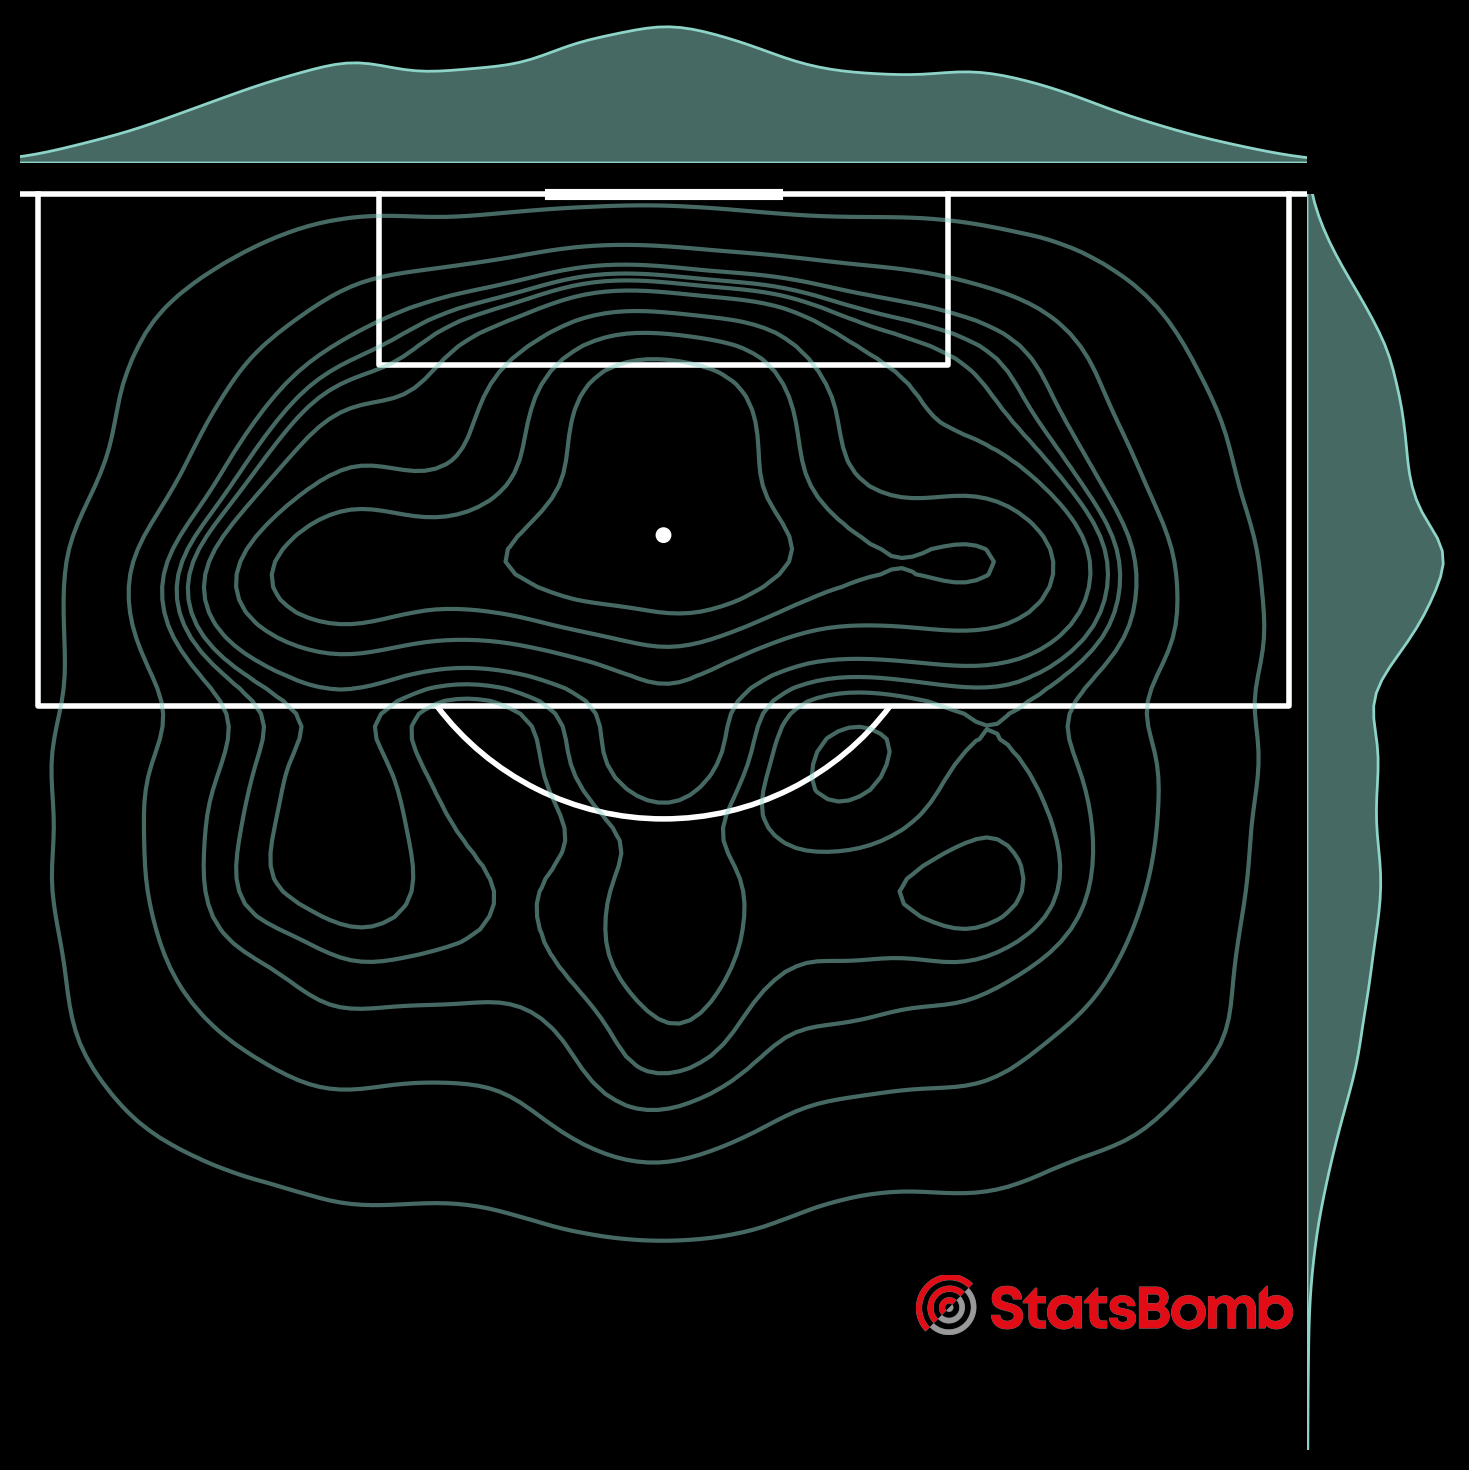

In [9]:
joint_kws = {'fill': False, 'lw': 3, 'bw_method': 'scott', 'alpha': 0.5}
fig, axs = pitch.jointgrid(figheight=10, ax_left=False, title_height=0, endnote_height=0)
pitch.kdeplot(df_shots.x, df_shots.y, ax=axs['pitch'], **joint_kws)
ax_image1 = add_image(logo, fig, left=0.62, bottom=0.2, width=0.25, alpha=1, interpolation='hanning')
kde_x = sns.kdeplot(x=df_shots.y, ax=axs['top'], fill=True, alpha=0.5)
kde_y = sns.kdeplot(y=df_shots.x, ax=axs['right'], fill=True, alpha=0.5)
axs['top'].axis('off')
axs['right'].axis('off')
fig.savefig(os.path.join('..', 'figures', '10_kde_shots_scott_example.png'),
          bbox_inches = 'tight', pad_inches = 0)

# Shot distribution using Kernel Density Estimation and bandwidth 2

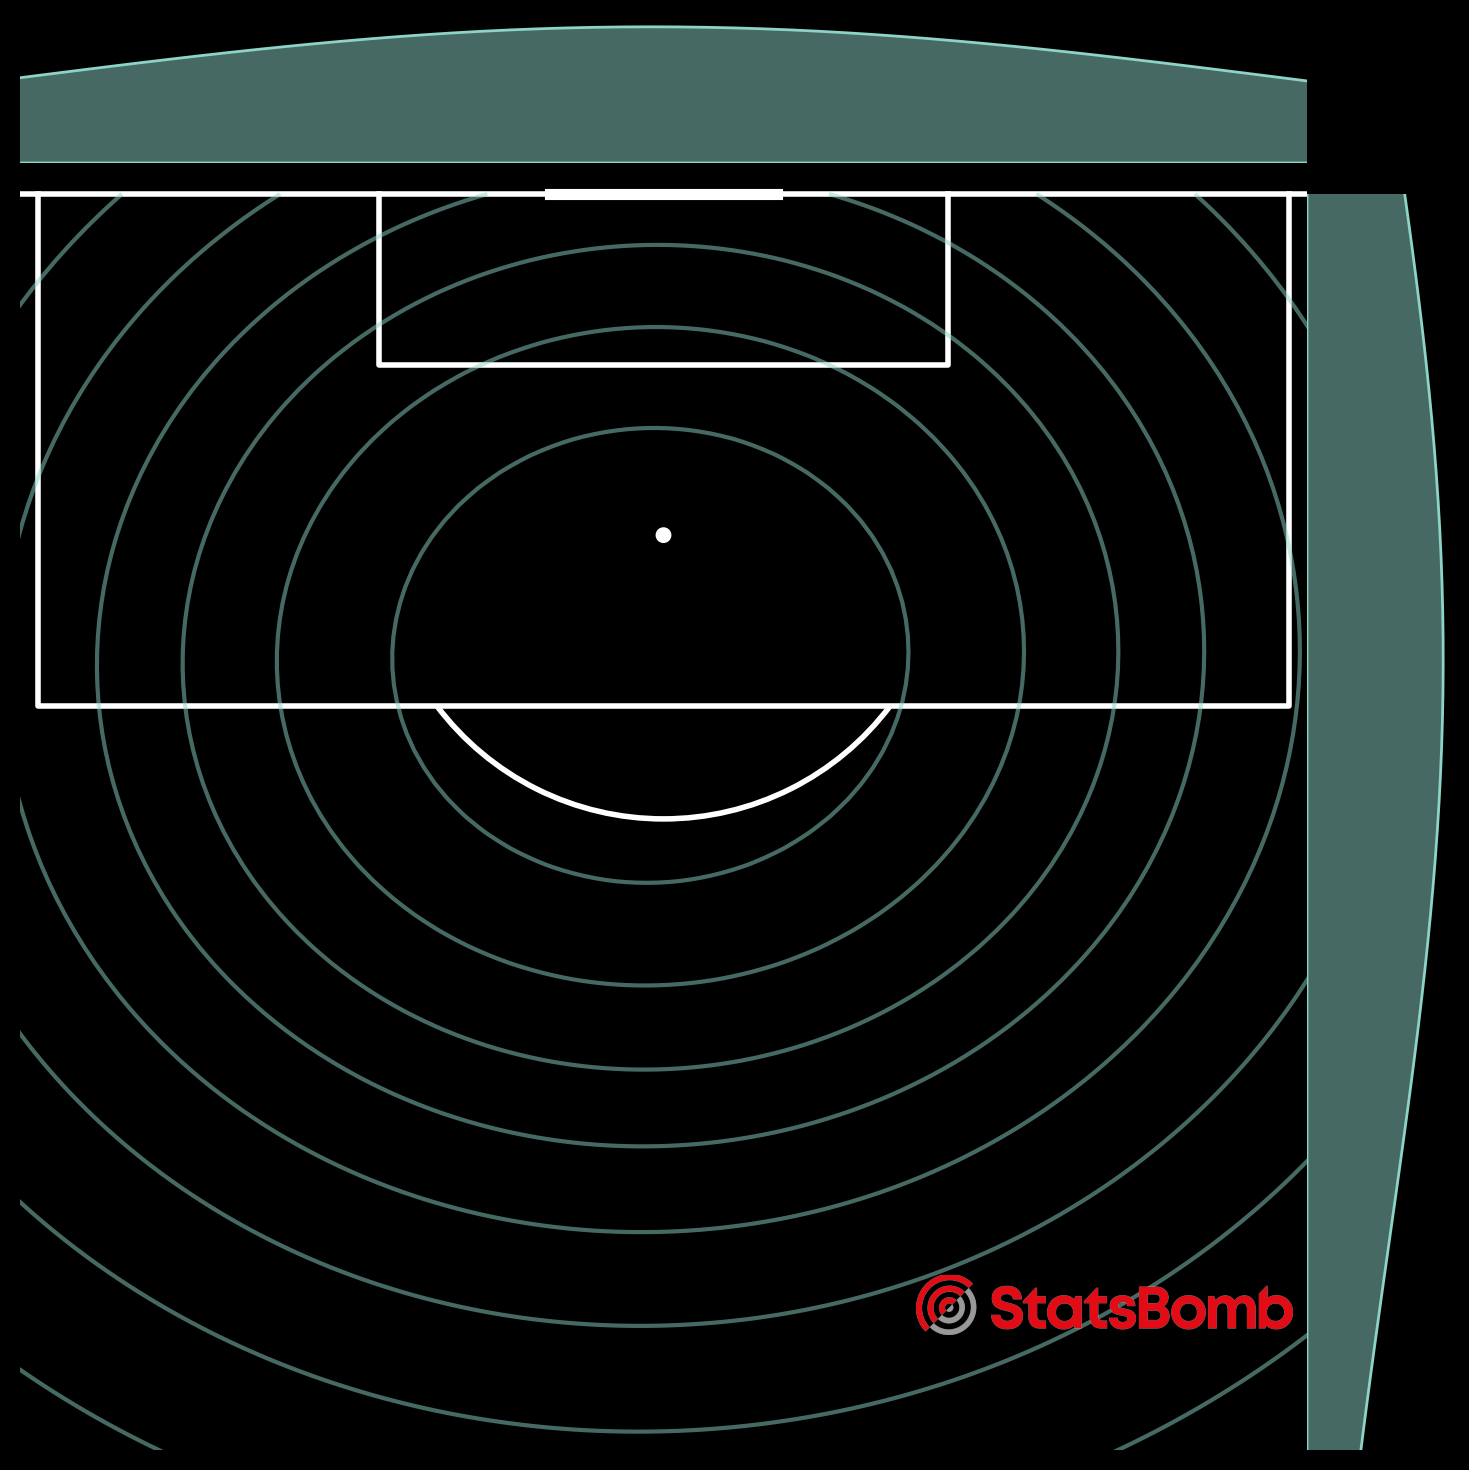

In [10]:
joint_kws = {'fill': False, 'lw': 3, 'bw_method': 2, 'alpha': 0.5}
fig, axs = pitch.jointgrid(figheight=10, ax_left=False, title_height=0, endnote_height=0)
pitch.kdeplot(df_shots.x, df_shots.y, ax=axs['pitch'], **joint_kws)
ax_image1 = add_image(logo, fig, left=0.62, bottom=0.2, width=0.25, alpha=1, interpolation='hanning')
kde_x = sns.kdeplot(x=df_shots.y, ax=axs['top'], fill=True, alpha=0.5, bw_method=2)
kde_y = sns.kdeplot(y=df_shots.x, ax=axs['right'], fill=True, alpha=0.5, bw_method=2)
axs['top'].axis('off')
axs['right'].axis('off')
fig.savefig(os.path.join('..', 'figures', '11_kde_shots_high_bandwidth_example.png'),
          bbox_inches = 'tight', pad_inches = 0)

# Fitting a cross-validated Kernel Density estimator

In [11]:
df_shots.reset_index(drop=True, inplace=True)

In [12]:
X = df_shots[['x', 'y']]
y = df_shots.goal

In [13]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(df_shots[['x', 'y']], df_shots.goal)

10

Recreate the same splits for the goals as the shots

In [14]:
df_shots['goal_number'] = df_shots.goal.cumsum() - 1
goals_cv = []
shots_cv = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    split_train_shots = X.iloc[train_index]
    split_test_shots = X.iloc[test_index]
    split_train_y = y.iloc[train_index]
    split_test_y = y.iloc[test_index]
    split_train_goals = split_train_shots[split_train_y]
    split_test_goals = split_test_shots[split_test_y]
    goals_train_idx = split_train_goals.index.tolist()
    goals_test_idx = split_test_goals.index.tolist()
    goals_train_idx = df_shots.iloc[goals_train_idx].goal_number.tolist()
    goals_test_idx = df_shots.iloc[goals_test_idx].goal_number.tolist()
    goals_cv.append((goals_train_idx, goals_test_idx))
    shots_cv.append((train_index, test_index))
df_goals.reset_index(drop=True, inplace=True)

In [15]:
param_grid = {'bandwidth': np.linspace(0.5, 1.5, 40)}
grid_goals = GridSearchCV(KernelDensity(kernel='gaussian', rtol=0.0001), param_grid=param_grid , cv=goals_cv, n_jobs=-1)
grid_goals.fit(df_goals[['x', 'y']])
print(grid_goals.best_estimator_.bandwidth)

0.9871794871794872


In [16]:
grid_shots = GridSearchCV(KernelDensity(kernel='gaussian', rtol=0.0001), param_grid=param_grid , cv=shots_cv, n_jobs=-1)
grid_shots.fit(df_shots[['x', 'y']])
print(grid_shots.best_estimator_.bandwidth)

0.9871794871794872


In [17]:
kernel_middle = (grid_shots.best_estimator_.bandwidth + grid_goals.best_estimator_.bandwidth) / 2
print(kernel_middle)

0.9871794871794872


# Plot both on same pitch

In [18]:
kernel_middle = 0.9871794871794872

In [19]:
model_goals = KernelDensity(kernel='gaussian', bandwidth=kernel_middle)
model_shots = KernelDensity(kernel='gaussian', bandwidth=kernel_middle)

In [20]:
model_goals.fit(df_goals[['x', 'y']])
model_shots.fit(df_shots[['x', 'y']])

KernelDensity(bandwidth=0.9871794871794872)

In [21]:
x_grid = np.arange(0, 105.1, 0.25)
y_grid = np.arange(0, 68.1, 0.25)
X, Y = np.meshgrid(x_grid, y_grid)
sample = np.vstack([X.ravel(), Y.ravel()]).T

In [22]:
goal_scores = np.exp(model_goals.score_samples(sample))

In [23]:
shot_scores = np.exp(model_shots.score_samples(sample))

In [24]:
shot_scores = shot_scores.reshape(X.shape)
goal_scores = goal_scores.reshape(X.shape)

In [25]:
n_shots = len(df_shots)
n_goals = len(df_goals)

In [26]:
goal_scores.shape

(273, 421)

In [27]:
shot_scores.shape

(273, 421)

In [28]:
n_goals

7895

In [29]:
n_shots

74958

In [30]:
prob_scoring = ((goal_scores/shot_scores) * (n_goals / n_shots))

C:\Users\ay54372\AppData\Local\Temp\ipykernel_3064\2600861707.py:1: RuntimeWarning: invalid value encountered in true_divide
  prob_scoring = ((goal_scores/shot_scores) * (n_goals / n_shots))


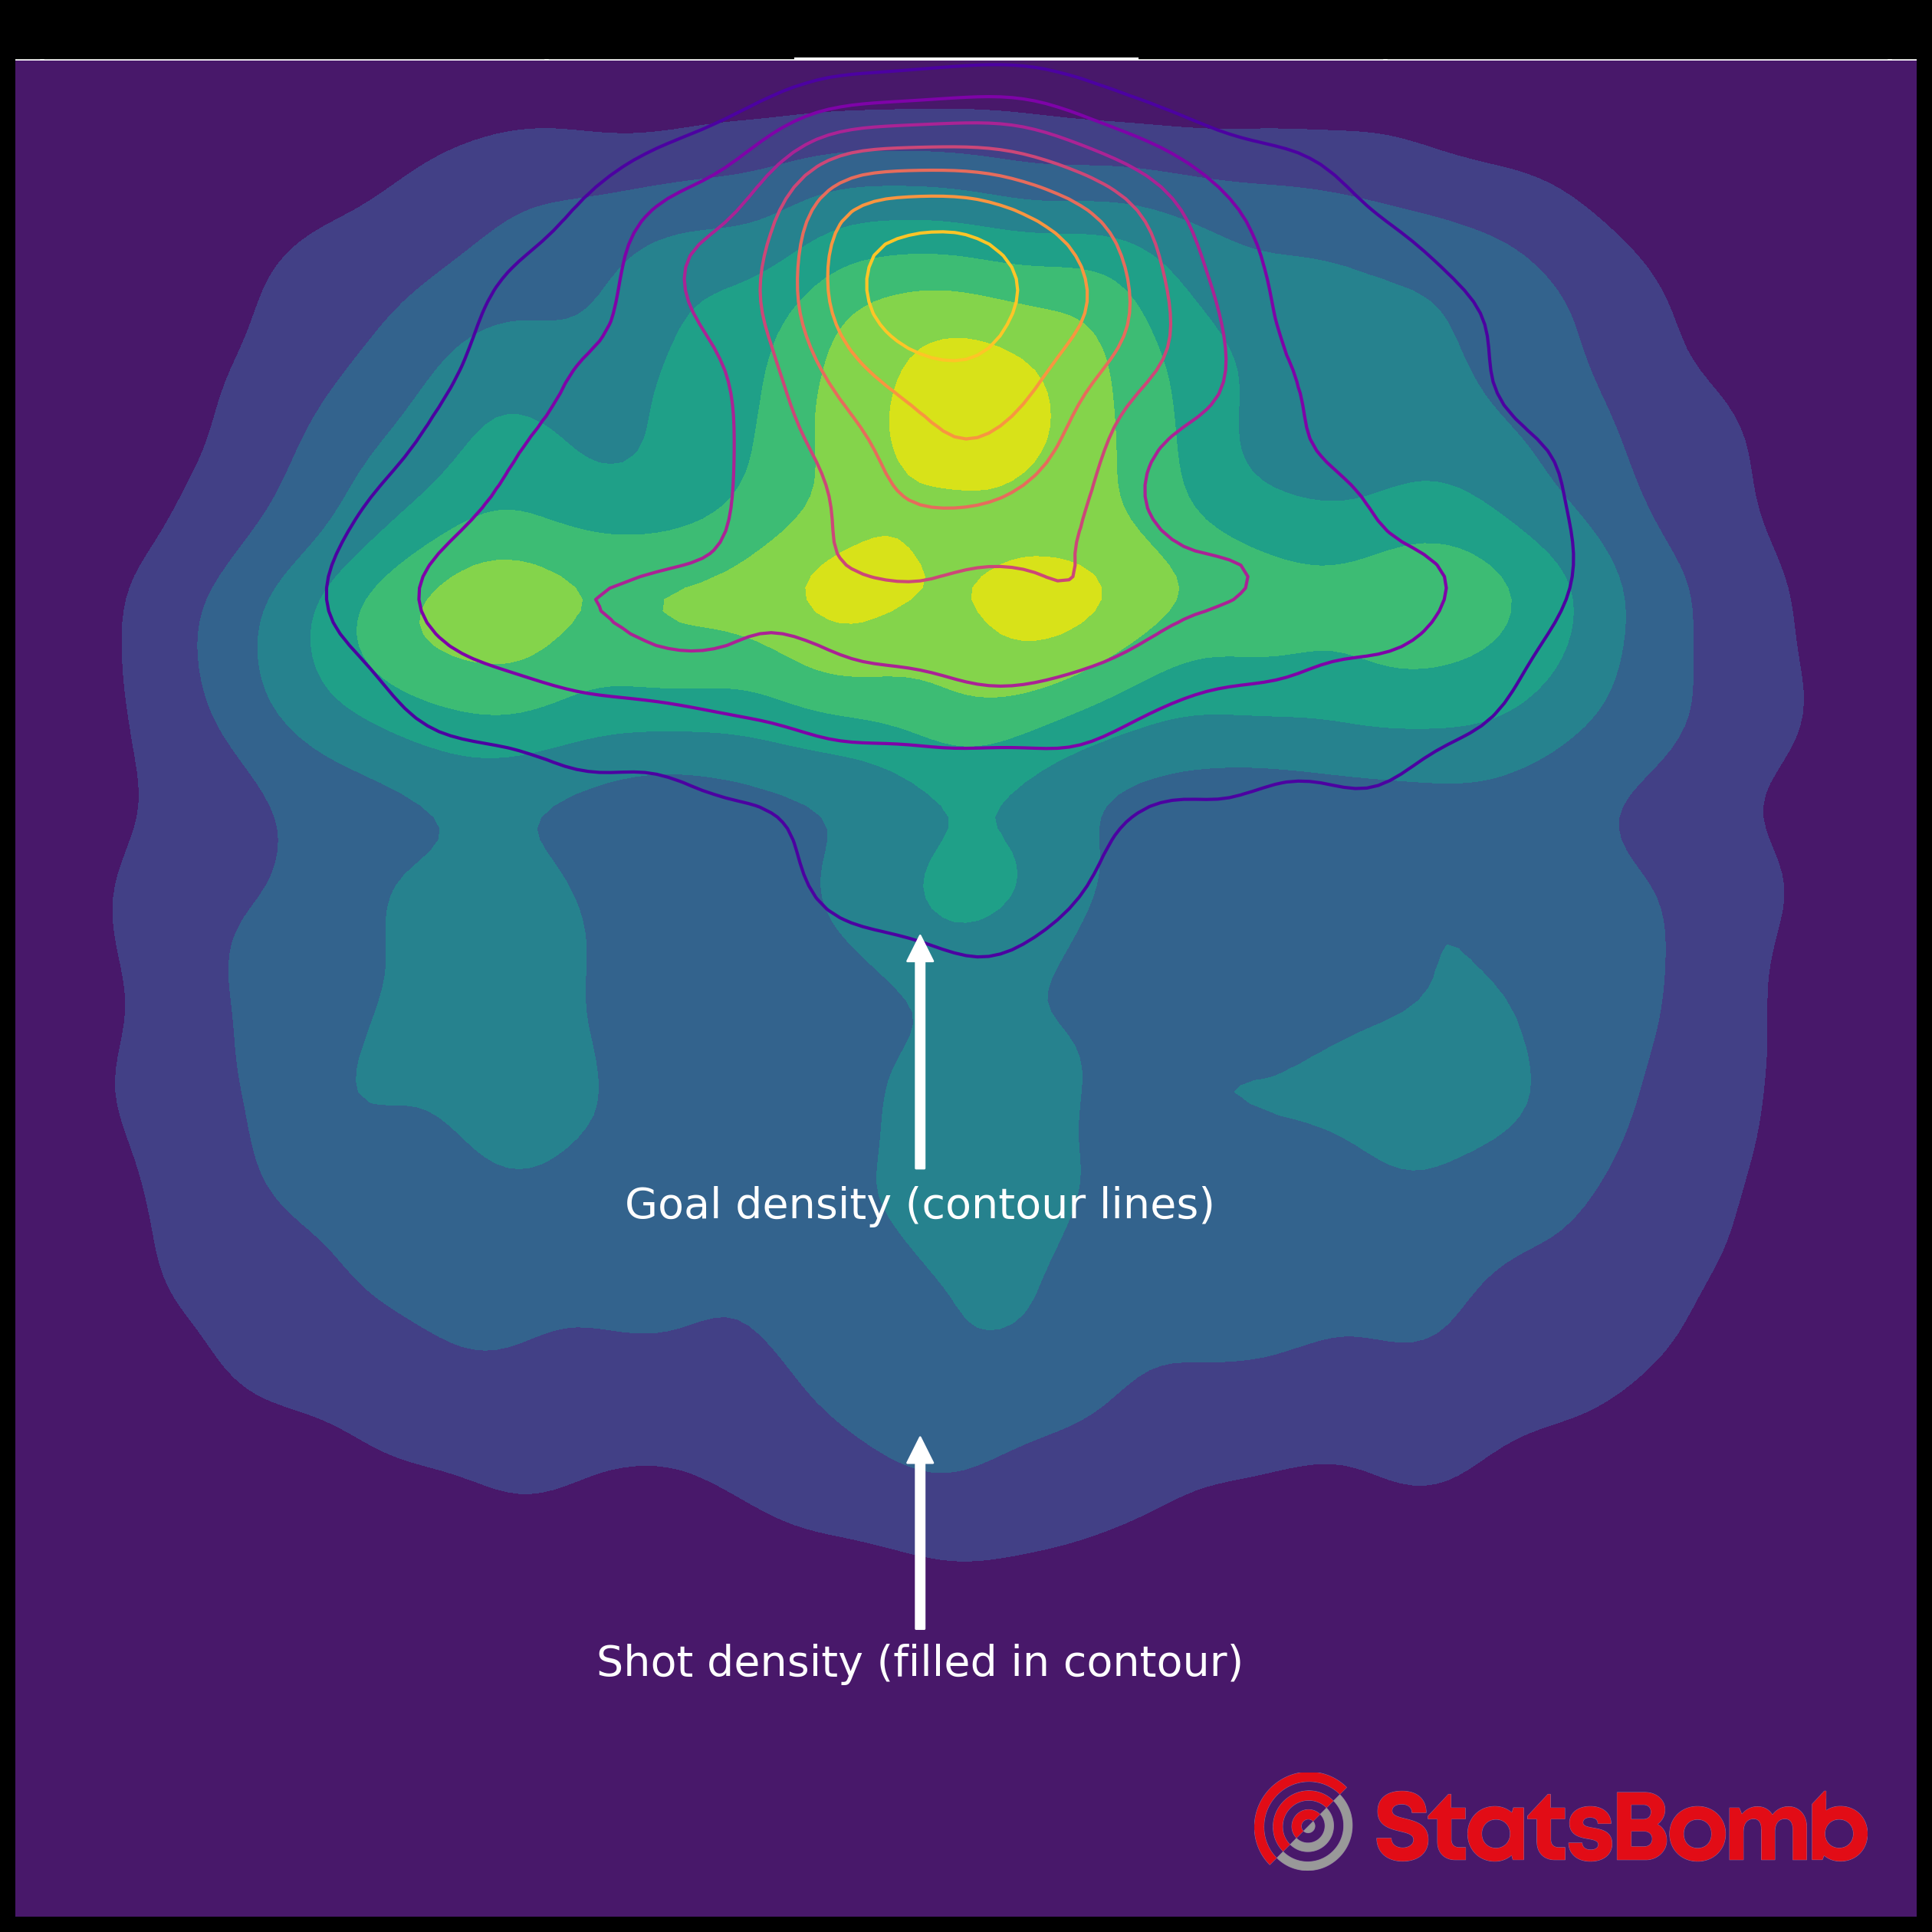

In [31]:
pitch = VerticalPitch(half=True, line_zorder=2, pitch_type='uefa',
                      pad_left=-13.25, pad_right=-13.25, pad_bottom=-12, pad_top=1)
fig, ax = pitch.draw(figsize=(16, 20), tight_layout=False)
contour1 = ax.contourf(Y, X, shot_scores, cmap='viridis', zorder=2, alpha=1)
contour2 = ax.contour(Y, X, goal_scores, cmap='plasma', zorder=2, alpha=1)
pitch.annotate('Shot density (filled in contour)', (75.2, 35), (70, 35), arrowprops=dict(facecolor='white', shrink=0.05),
               fontsize=20, va='center', ha='center', ax=ax)
pitch.annotate('Goal density (contour lines)', (86.2, 35), (80, 35), arrowprops=dict(facecolor='white', shrink=0.05),
               fontsize=20, va='center', ha='center', ax=ax)
ax_image1 = add_image(logo, fig, left=0.63, bottom=0.2, width=0.25, alpha=1, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '29_kde_shot_and_goal.png'), bbox_inches='tight', pad_inches=0)

In [32]:
prob_scoring = prob_scoring * 100

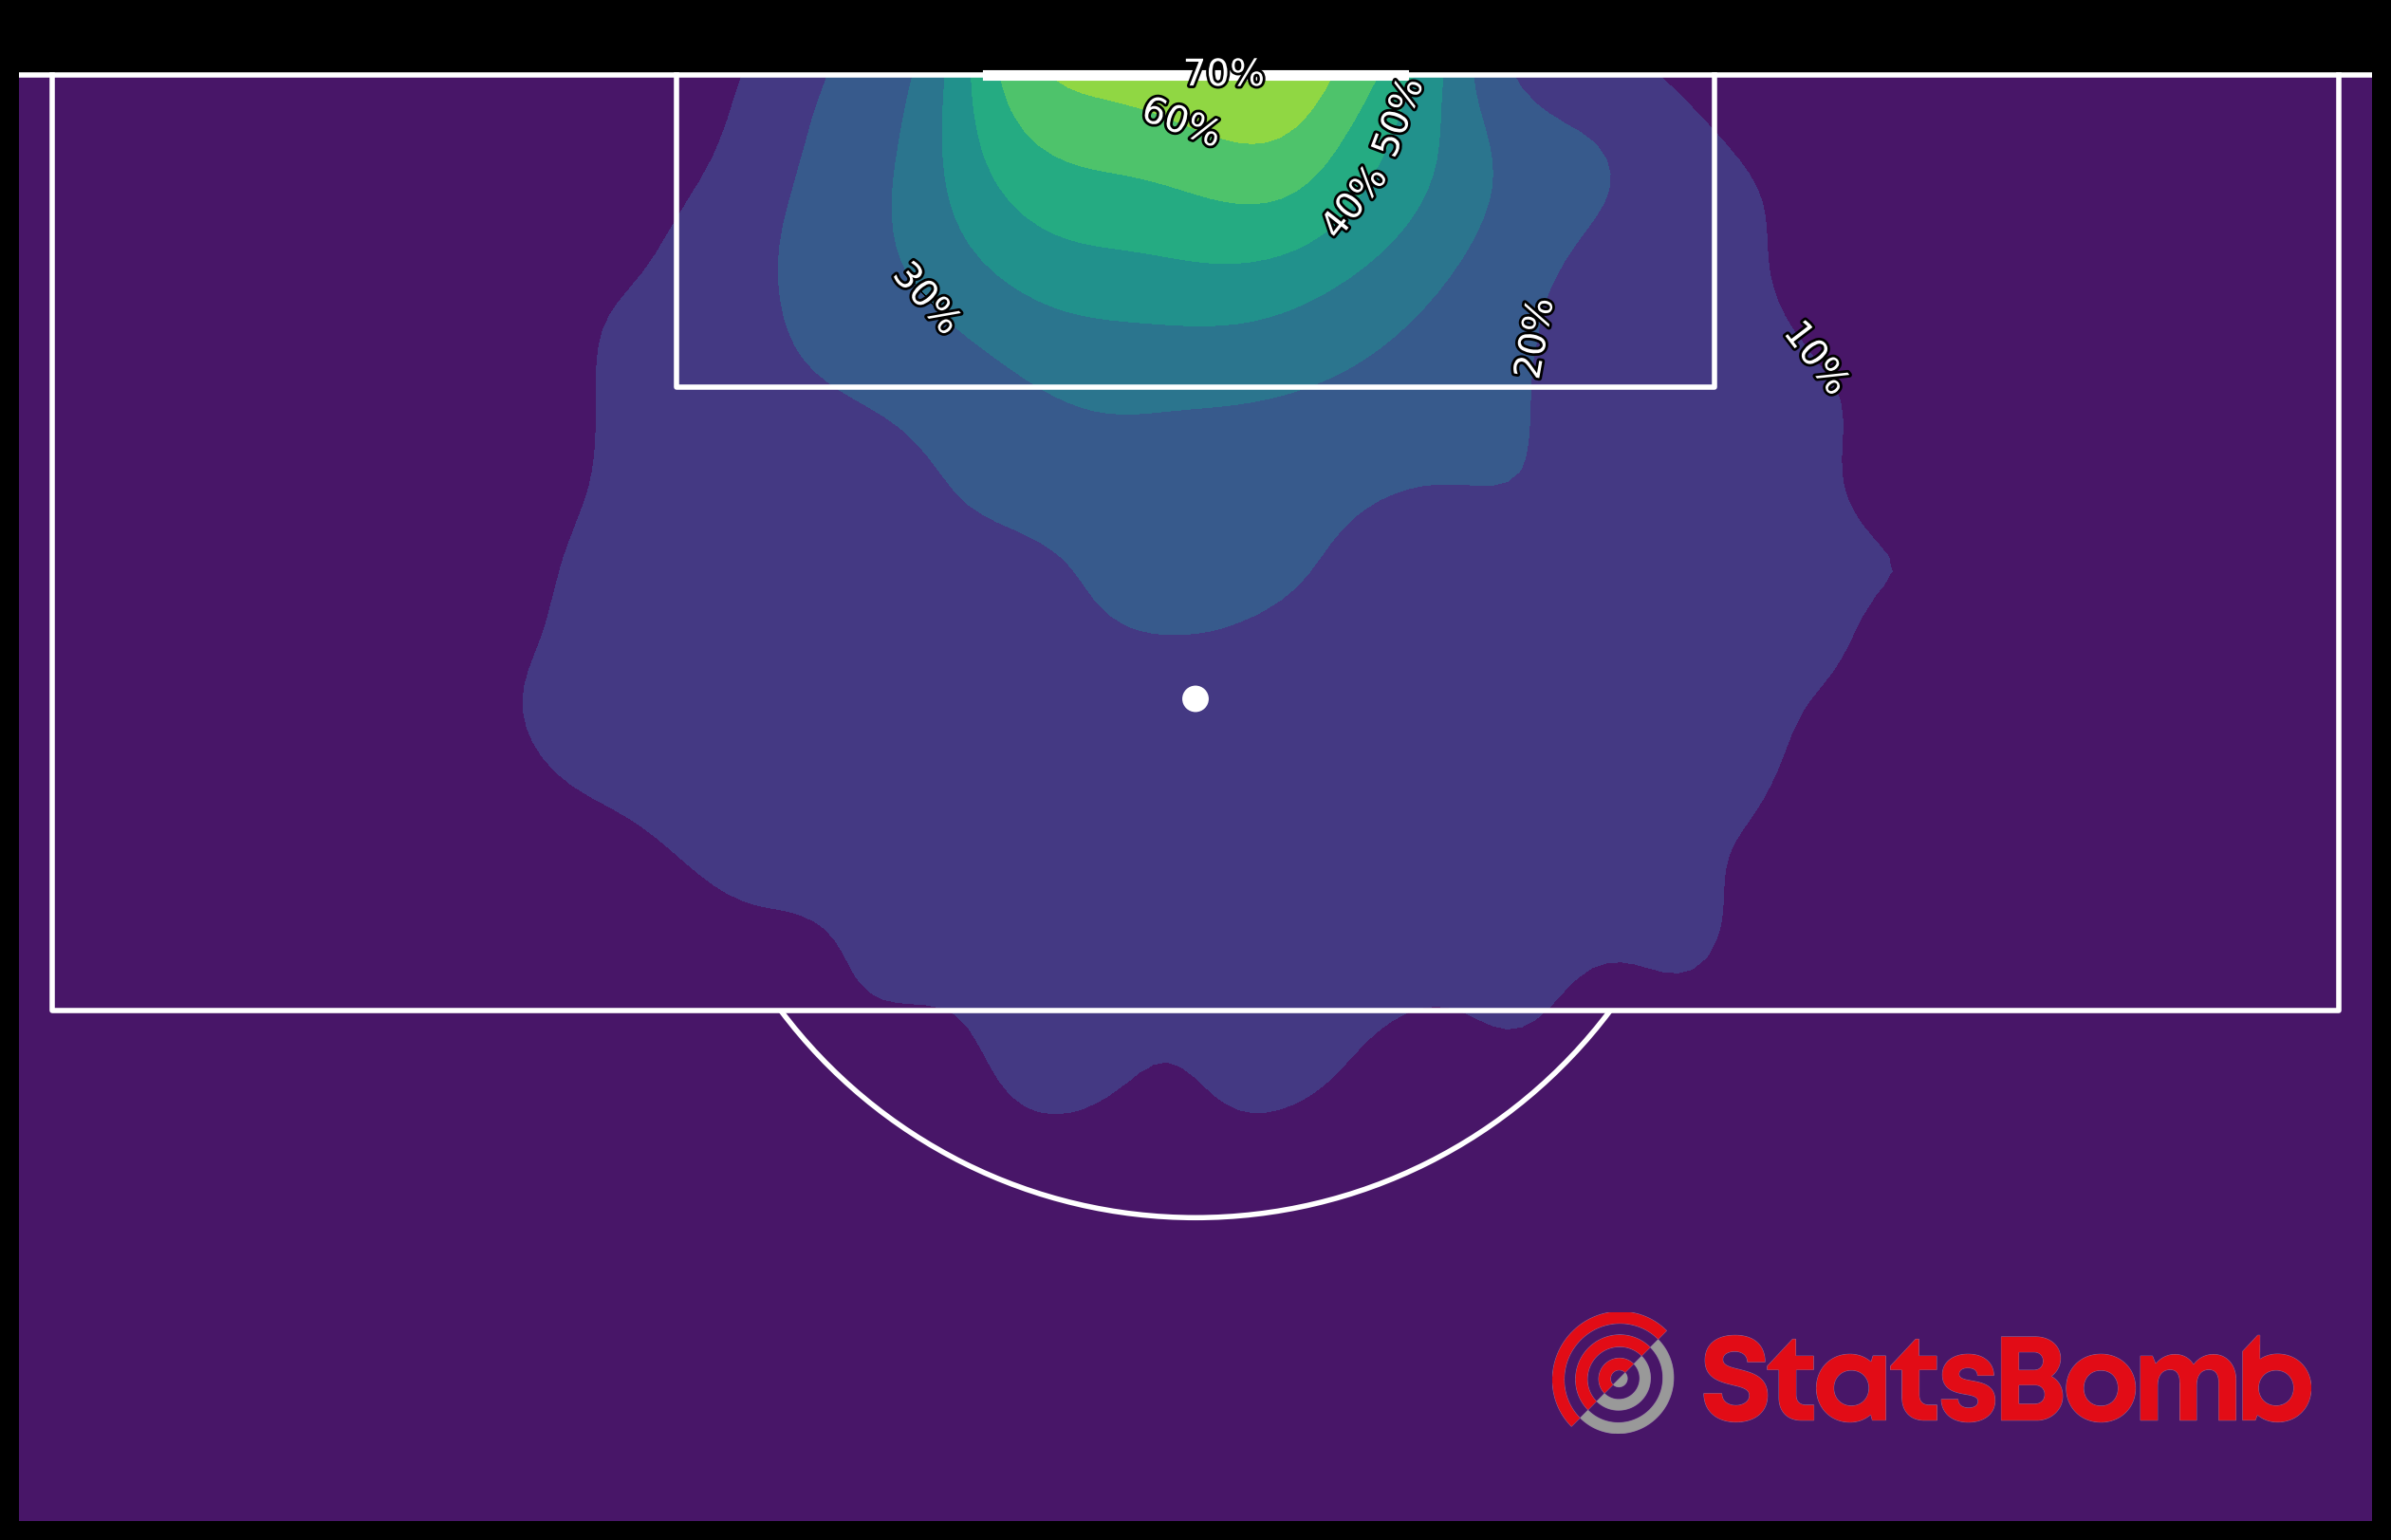

In [33]:
pitch = VerticalPitch(half=True, line_zorder=5, pitch_type='uefa',
                      pad_left=-13.25, pad_right=-13.25, pad_bottom=-27, pad_top=1)
fig, ax = pitch.draw(figsize=(16, 20), tight_layout=False)
ax_image1 = add_image(logo, fig, left=0.63, bottom=0.32, width=0.25, alpha=1, interpolation='hanning')
contour1 = ax.contourf(Y, X, prob_scoring, cmap='viridis', levels=9, zorder=2, alpha=1)
label = ax.clabel(contour1, colors='white', fontsize=14, fmt='%d%%', use_clabeltext=True, inline=True, zorder=6)
for l in label:
    l.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

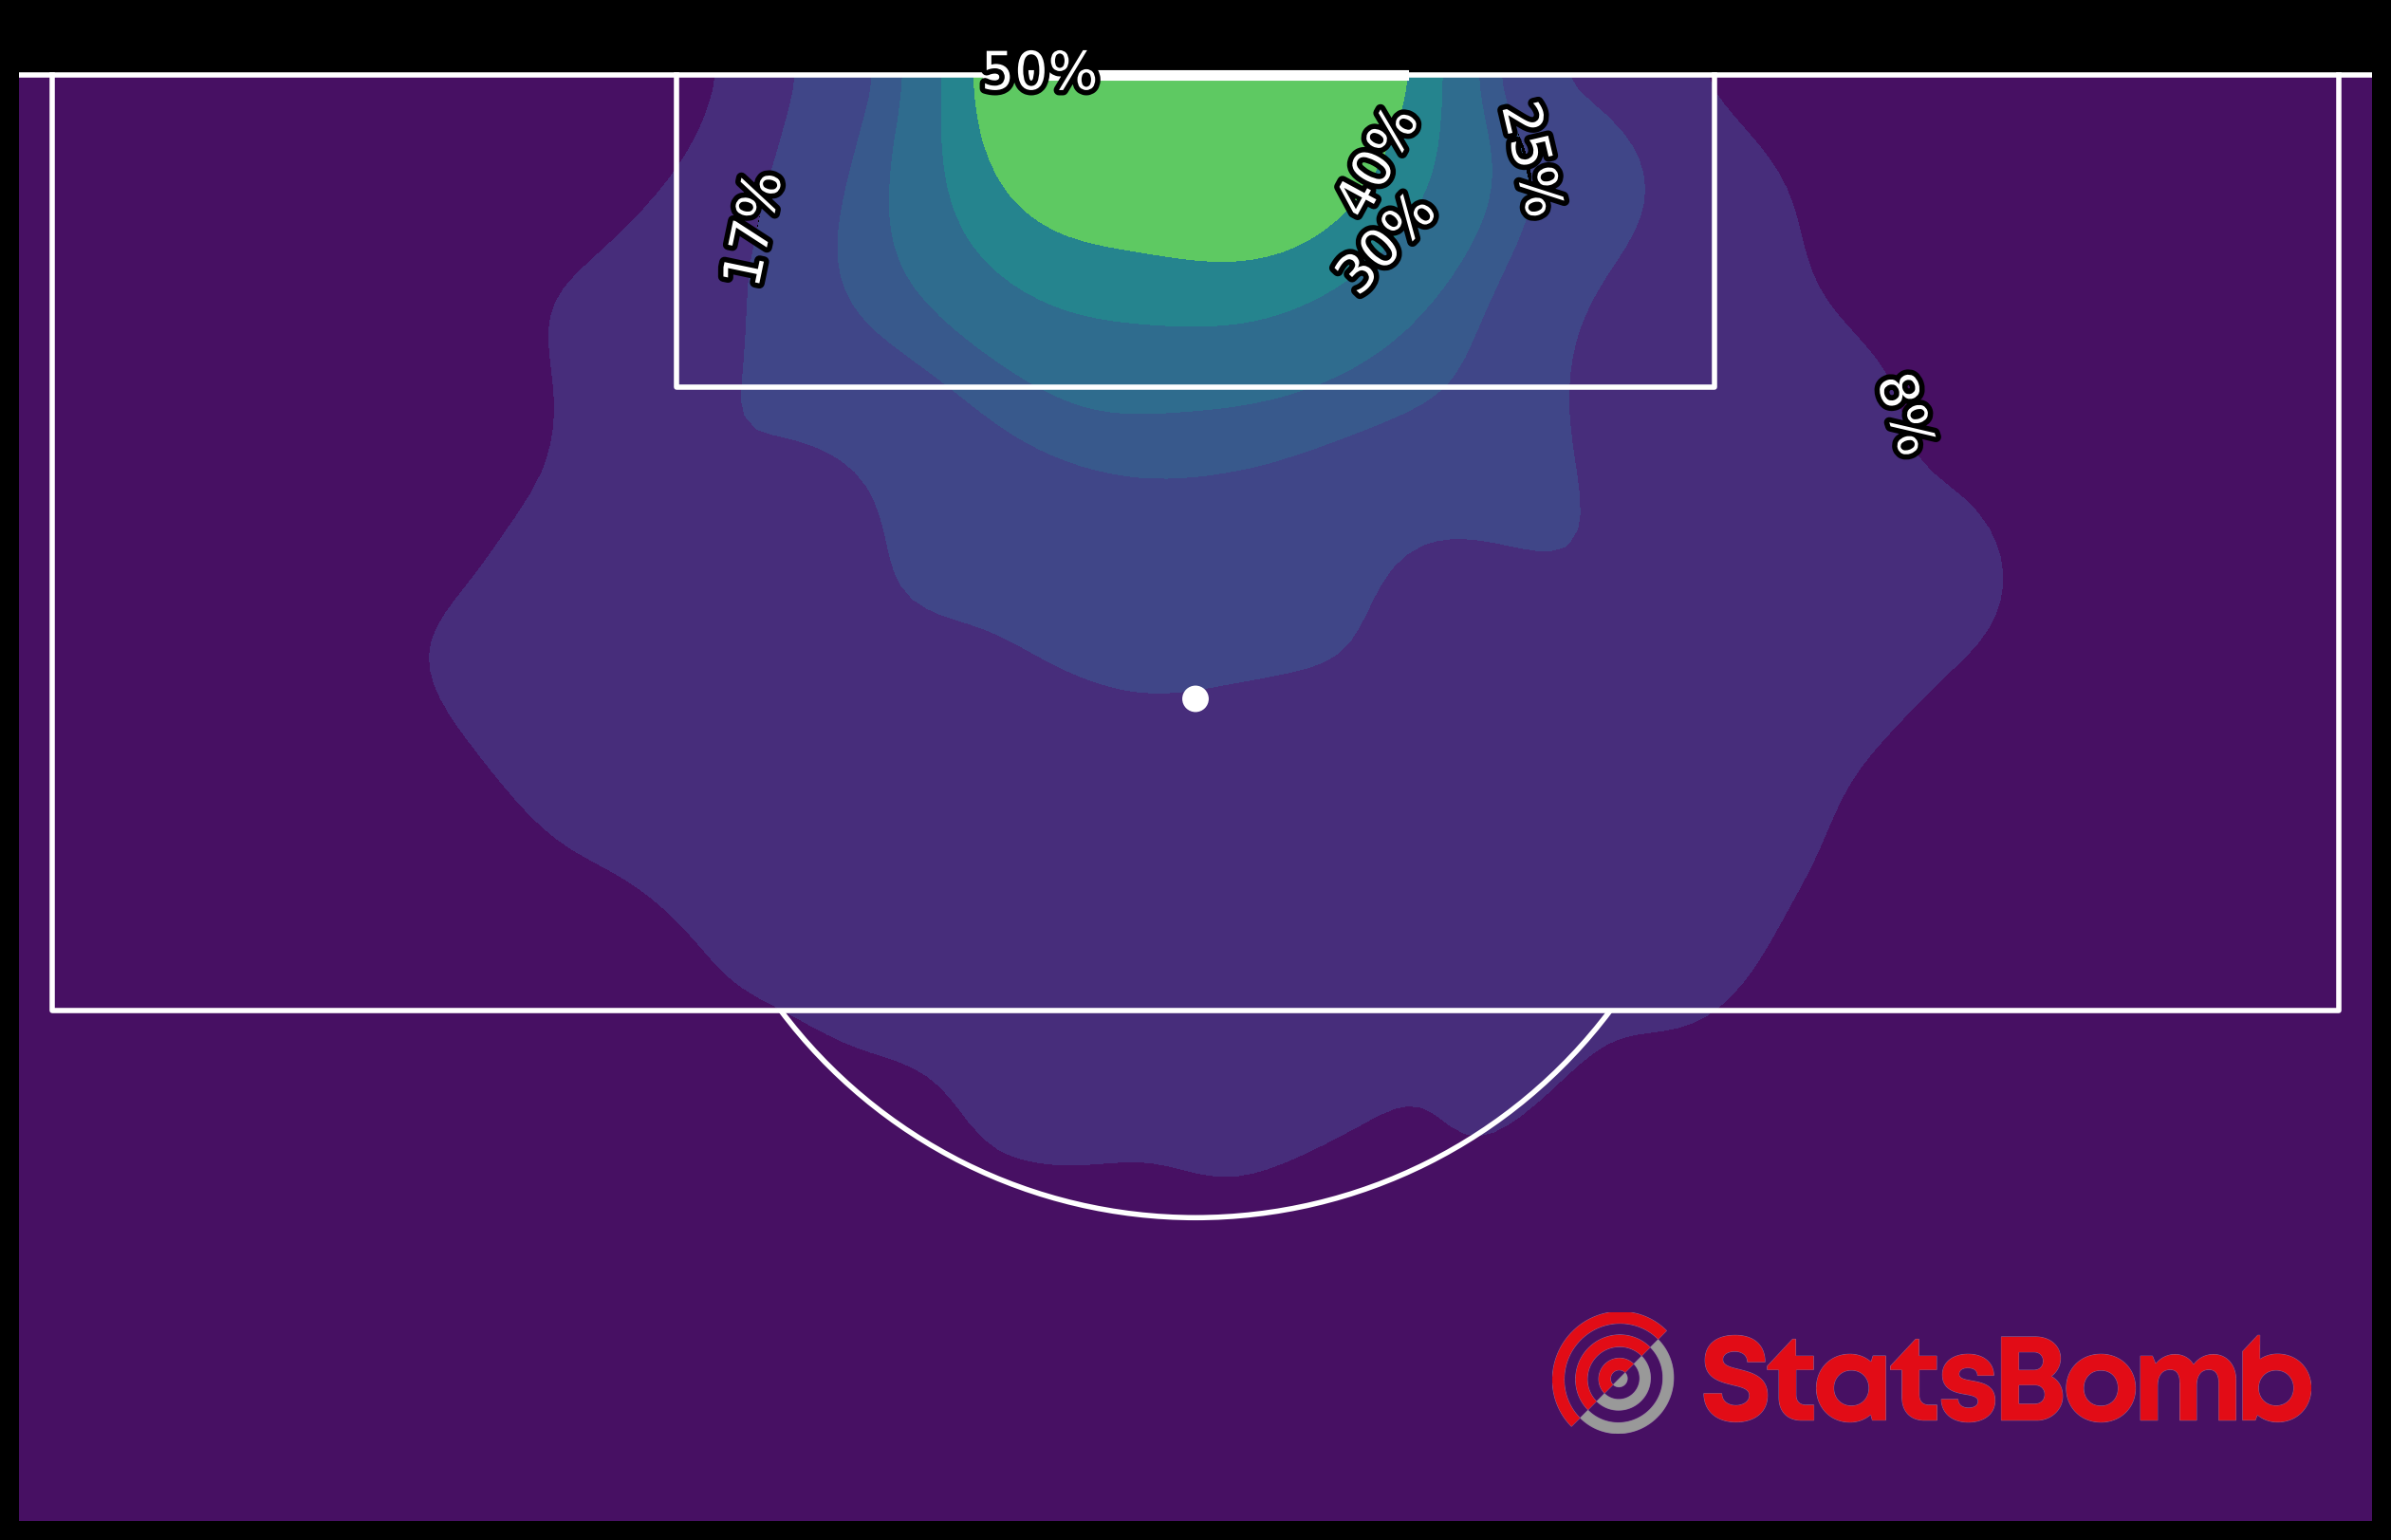

In [34]:
fig, ax = pitch.draw(figsize=(16, 20), tight_layout=False)
ax_image1 = add_image(logo, fig, left=0.63, bottom=0.32, width=0.25, alpha=1, interpolation='hanning')
levels = np.array([0, 8, 17, 25, 30, 40, 50, 100])
prob_scoring_smooth = gaussian_filter(prob_scoring, 2)
contour1 = ax.contourf(Y, X, prob_scoring_smooth, cmap='viridis', levels=levels, zorder=2, alpha=1)
label = ax.clabel(contour1, colors='white', fontsize=20, fmt='%d%%', inline=True, use_clabeltext=True, zorder=6)
for l in label:
    l.set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'), path_effects.Normal()])
fig.savefig(os.path.join('..', 'figures', '30_kde_estimated_probability_of_scoring.png'),
            bbox_inches = 'tight', pad_inches = 0)